In [186]:
import pandas as pd
import matplotlib.pyplot as plt

from gensim.models.ldamodel import LdaModel
from gensim import corpora
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS

In [84]:
from collections import Counter
import nltk
import re as regex
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from time import time
import gensim

In [189]:
tweets = pd.read_json('../data/the519_tweets.json')
tweets['YYYYMM'] = tweets['timestamp'].map(lambda x: str(x.year) + '-' + str(x.month))

In [190]:
tweets.dtypes

fullname             object
id                    int64
likes                 int64
replies               int64
retweets              int64
text                 object
timestamp    datetime64[ns]
user                 object
YYYYMM               object
dtype: object

In [191]:
tweet_date_counts = tweets.groupby(['YYYYMM']).size()

In [193]:
tweet_date_counts_2017 = tweet_date_counts[tweet_date_counts.index > '2017-00']

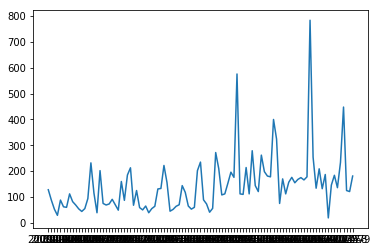

In [194]:
plt.plot(tweet_date_counts.index, tweet_date_counts.values)
plt.show()

In [96]:
class TwitterData_Initialize():
    data = []
    processed_data = []
    wordlist = []

    data_model = None
    data_labels = None
    is_testing = False
    
    def initialize(self, json_file, is_testing_set=False, from_cached=None):
        if from_cached is not None:
            self.data_model = pd.read_json(from_cached)
            return

        self.is_testing = is_testing_set

        self.data = pd.read_json(json_file)
        self.processed_data = self.data
        self.wordlist = []
        self.data_model = None
        self.data_labels = None

In [88]:
class TwitterCleanuper:
    def iterate(self):
        for cleanup_method in [self.remove_urls,
                               self.remove_usernames,
                               self.remove_na,
                               self.remove_special_chars,
                               self.remove_numbers]:
            yield cleanup_method

    @staticmethod
    def remove_by_regex(tweets, regexp):
        tweets.loc[:, "text"].replace(regexp, "", inplace=True)
        return tweets

    def remove_urls(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"http.?://[^\s]+[\s]?"))

    def remove_na(self, tweets):
        return tweets[tweets["text"] != "Not Available"]

    def remove_special_chars(self, tweets):  # it unrolls the hashtags to normal words
        for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "#"]):
            tweets.loc[:, "text"].replace(remove, "", inplace=True)
        return tweets

    def remove_usernames(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

    def remove_numbers(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

In [89]:
class TwitterData_Cleansing(TwitterData_Initialize):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def cleanup(self, cleanuper):
        t = self.processed_data
        for cleanup_method in cleanuper.iterate():
            if not self.is_testing:
                t = cleanup_method(t)
            else:
                if cleanup_method.__name__ != "remove_na":
                    t = cleanup_method(t)

        self.processed_data = t

In [161]:
data = TwitterData_Initialize()
data.initialize('../data/the519_tweets.json')
data = TwitterData_Cleansing(data)
data.cleanup(TwitterCleanuper())

In [164]:
class TwitterData_TokenStem(TwitterData_Cleansing):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def stem(self, stemmer=nltk.PorterStemmer()):
        def stem_and_join(row):
            row["text"] = list(map(lambda str: stemmer.stem(str.lower()), row["text"]))
            return row

        self.processed_data = self.processed_data.apply(stem_and_join, axis=1)

    def tokenize(self, tokenizer=nltk.word_tokenize):
        def tokenize_row(row):
            row["text"] = tokenizer(row["text"].lower())
            row["tokenized_text"] = [] + row["text"]
            return row

        self.processed_data = self.processed_data.apply(tokenize_row, axis=1)

In [165]:
data = TwitterData_TokenStem(data)
data.tokenize()
data.stem()

In [171]:
data.processed_data['tokenized_text']

0        [excited, for, our, new, online, presence, vis...
1        [were, looking, for, new, members, for, our, b...
2        [rt, were, looking, for, new, members, for, ou...
3        [rt, rt, were, looking, for, new, members, for...
4        [rt, were, looking, for, new, members, for, ou...
5                                   [thanks, for, the, rt]
6                                  [happy, charitytuesday]
7        [our, communities, meet, check, out, our, webs...
8        [toronto, tweeps, aka, the, fab, church, st, c...
9        [rt, toronto, tweeps, aka, the, fab, church, s...
10       [thanks, for, the, shoutout, were, excited, to...
11       [um, no, need, parroti, agreeim, just, not, in...
12       [rt, toronto, tweeps, aka, the, fab, church, s...
13       [rt, rt, toronto, tweeps, aka, the, fab, churc...
14       [rt, so, who, is, going, to, join, pride, toro...
15          [prideto, welcomes, our, friends, to, twitter]
16       [rain, is, rhythmically, pouring, down, on, th.

In [183]:
documents = [[word for word in document if word not in stopwords.words('english')] for document in data.processed_data['text']]
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]

In [184]:
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=25)

In [185]:
lda.print_topics()

[(24,
  '0.053*"lgbtq" + 0.050*"volunt" + 0.039*"creat" + 0.030*"share" + 0.026*"fair" + 0.025*"inclus" + 0.018*"aid" + 0.017*"particip" + 0.017*"commun" + 0.015*"vigil"'),
 (13,
  '0.052*"job" + 0.034*"cook" + 0.031*"bodi" + 0.029*"still" + 0.025*"regist" + 0.022*"like" + 0.018*"youth" + 0.014*"care" + 0.013*"support" + 0.011*"chariti"'),
 (4,
  '0.026*"mon" + 0.022*"st" + 0.018*"dropin" + 0.017*"church" + 0.017*"mtg" + 0.013*"food" + 0.013*"recreat" + 0.012*"local" + 0.012*"pink" + 0.012*"view"'),
 (23,
  '0.039*"’" + 0.038*"gala" + 0.029*"go" + 0.021*"act" + 0.020*"thi" + 0.018*"support" + 0.016*"sat" + 0.013*"advocaci" + 0.013*"friend" + 0.013*"perform"'),
 (21,
  '0.067*"commun" + 0.037*"toronto" + 0.035*"centr" + 0.030*"lgbtq" + 0.029*"street" + 0.028*"folk" + 0.027*"church" + 0.019*"thur" + 0.018*"meet" + 0.015*"discuss"'),
 (22,
  '0.041*"…" + 0.028*"everi" + 0.023*"ta" + 0.021*"free" + 0.020*"monday" + 0.015*"octob" + 0.012*"rd" + 0.012*"season" + 0.011*"sex" + 0.011*"held"'),

In [188]:
tweets['text']

0        Excited for our new online presence.  Visit ou...
1        We're looking for new members for our Board of...
2        RT @The519 We're looking for new members for o...
3        RT @matthewcutler: RT @The519 We're looking fo...
4        RT @The519 We're looking for new members for o...
5        @PrideToronto @UnionSt @MatthewCutler  -  Than...
6                                   Happy #CharityTuesday!
7        Our communities meet @The519  - Check out our ...
8        Toronto Tweeps - @The519 (aka the fab 519 Chur...
9        RT @Toronto_PR_Guy: Toronto Tweeps - @The519 (...
10       @Toronto_PR_Guy Thanks for the shout-out! We'r...
11       @The519 um, no need 2 parrot.I agree-I'm just ...
12       RT @Toronto_PR_Guy: Toronto Tweeps - @The519 (...
13       RT @UnionSt: RT @Toronto_PR_Guy: Toronto Tweep...
14       RT @pride_ed: So who is going to join Pride To...
15       #PrideTO welcomes our friends @The519 to Twitter!
16       Rain is rhythmically pouring down on the skyli.